# **Twitter Sentiment Analysis:** 
### *Understanding Public Sentiment on Apple and Google Products via Twitter*

## **Business Understanding**
### **Background**
In today’s highly competitive technology industry, public opinion plays a major role in shaping brand reputation, customer loyalty, and product adoption. Tech giants such as Apple, Google, and Android consistently dominate online conversations, with Twitter (X) serving as a powerful platform where users openly share their experiences, frustrations, and excitement.

Companies in the smartphone and software ecosystem rely heavily on social media platforms to understand how customers feel about their products, monitoring sentiment is crucial for:

- **Brand reputation management** – Understanding how consumers perceive Apple, Google, and Android products in real time.

- **Market intelligence** – Identifying user pain points, emerging trends, and competitive advantages.

- **Customer engagement** – Responding proactively to feedback to improve user experience.

- **Strategic decision-making** – Informing product development, marketing strategies, and customer support initiatives.

However, manually analyzing thousands of Tweets is time-consuming, inconsistent, and inefficient. There is a clear need for an automated system that can classify sentiment (positive, negative, or neutral) from user-generated content.

### **Problem Statement**
Despite the dominance of Apple, Google, and Android in the technology sector, their success is heavily influenced by consumer perception and online conversations. However, due to the vast and unstructured nature of Twitter data, it is difficult to systematically understand whether public opinion is positive, negative, or neutral. This creates a challenge for businesses and stakeholders who need actionable insights to improve brand reputation, customer engagement, and strategic decision-making.

### **Project Objectives**
This project seeks to analyze Twitter conversations about Apple, Google, and Android products using natural language processing (NLP) techniques. By classifying tweets into positive, negative, and neutral sentiments, the analysis will uncover the prevailing consumer opinions and brand perceptions.

Ultimately, the insights generated can support businesses, marketers, and stakeholders in the tech industry to track consumer sentiment, benchmark against competitors, and drive data-informed decisions.

### **StakeHolders**
- **Apple & Google Marketing Teams** – to measure customer reactions to new product launches and campaigns.

- **Product Development Teams** – to identify areas where users express dissatisfaction, helping guide improvements.

- **Customer Service Teams** – to proactively address common customer complaints raised on social media.

- **Business Analysts & Executives** – to monitor overall brand reputation and benchmark against competitors.

### **Value of the Project**

1. Enables real-time monitoring of brand sentiment on Twitter.

2. Provides actionable insights for marketing, customer service, and product strategy.

3. Reduces reliance on manual Tweet analysis, saving time and resources.

4. Helps companies track sentiment trends over time and respond faster to customer concerns.

### **In Scope**
- As a proof of concept, we will first attempt a binary classification (positive vs. negative).

- After that, we will extend to a multiclass classification (positive, negative, neutral).

*Out of scope: topics beyond Apple, Google, and Android, and advanced sentiment like sarcasm or irony detection.*

## **Data Understanding**
This section contains the data's initial exploration. It provides information about the source of the data, helps have a peek at the dataset to understand it's structure such as its shape, data types, etc. and also understand what kind of mess the data has, such as missing values, duplicated records, outliers, among other data integrity issues.

### **Data Source**
The dataset comes from CrowdFlower via [data.world](https://data.world/crowdflower/brands-and-product-emotions/workspace/file?filename=judge-1377884607_tweet_product_company.csv). It contains Tweets about Apple and Google products that have been human-labeled for sentiment.

#### *Why is this dataset important to the project?*
This dataset is highly suitable for our project because the text of Tweets directly reflects customer opinions. Analyzing these Tweets allows stakeholders (product managers, marketing teams) to understand public sentiment efficiently without manually reading thousands of messages.

### **Mini Exploration**
This section involves exploring the data to understand its structure as well as it's contents better. It will include;
- Importing relevant libraries and loading the dataset

- Checking it's shape, data types etc.

- Checking for data integrity issues

#### *Importing relevant packages*

In [34]:
# Import relevant packages.
import re
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [35]:
# Load dataset
text_df = pd.read_csv('../../assets/judge-1377884607_tweet_product_company.csv', encoding="ISO-8859-1")

# Preview the first 5 rows
text_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


#### *Data Summary: shapes, data types*
This section checks the dataset's shape and data types, this is important as it will help in identifying if the data is sufficient for modeling or not. We'll also know what kind of data we will be working with.

- We are using the `.shape()` method to check the dataset's shape.

In [36]:
# Shape of the dataset
print("Rows, Columns:", text_df.shape)

Rows, Columns: (9093, 3)


The dataset contains 9093 rows and 3 columns, giving us enough records to work with.

- We are using the `.info()` method to retrieve a concise summary of the data.

In [37]:
# Data types and non-null values
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


The dataset contains 3 columns and all contain values stored as objects. 

Also, 2 out of the 3 columns contain null values, that is the `tweet_text` and the `emotion_in_tweet_is_directed_at` columns.

#### *Checking Data Integrity Issues*
In this section we are looking to identify whether the data contains:
- Missing values

- Duplicated records

In [38]:
# Find total number and percentage of missing values.
# Retrieve sum of missing values.
missing = text_df.isnull().sum()

# Turn into percentage.
missing_percent = (missing / len(text_df)) * 100

# Store in a DataFrame.
missing_df = pd.DataFrame({'Missing Values': missing, 'Percent': missing_percent})

# Filter out columns that don't have missing values.
missing_df[missing_df['Missing Values'] > 0]

,Missing Values,Percent
tweet_text,1,0.010997
emotion_in_tweet_is_directed_at,5802,63.807324


As observed earlier, the data contains missing values in 2 columns. 1 missing value in the `tweet_text` column and in more than 60% records in the `emotion_in_tweet_is_directed_at` column.

- In the next cell we are checking for duplicates using the `.duplicated()` method.

In [39]:
# Check for duplicates
duplicate_records = text_df.duplicated().sum()

print(f'The dataset contains {duplicate_records} duplicate records')

The dataset contains 22 duplicate records


The data contains 22 duplicated records.

#### *Descriptive Analysis*
We are using the `.describe()` method to generate a summary description of the data.

In [40]:
# Summary stats for numerical columns
text_df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


- `tweet_text` contains 9093 records and 9065 unique values. This is a clear indication that we have duplicated rows in the dataset.

- `emotion_in_tweet_is_directed_at` contains 3219 records, has 9 unique values where ipad is the most frequent product with 946 reviews.

- `is_there_an_emotion_directed_at_a_brand_or_product` contains 9093 records and has 4 unique values where *No emotion toward brand or product* is the most frequent record with 5389 reveiws.

### **Data Understanding Summary**
#### *Structure*
The dataset contains structured data stored in 9,093 rows and 3 columns, with records in all the columns stored as objects.

#### *Data Issues and the Next Steps*
| Found                 |    Action                                                          |
| --------------------- | ------------------------------------------------------------------ |
| Missing values        | Replace or drop                                                    |
| Duplicates            | Drop using `.drop_duplicates()`                                    |
| Long column names     | Replace with short, easy names                                     |
| Categorical issues    | Fix inconsistent labels (If any)                                   |

## **Data Cleaning**
In this section we are cleaning the dataset to prepare it for modeling. In the previous section, we performed the initial data exploration which not only helped in understanding the dataset but also pointing out some of the issues that could otherwise mislead the project's findings.

This is a crucial step for any project before training a machine learning model because it ensures the data is accurate, consistent, and relevant, leading to better model performance and more reliable predictions. Cleaning data helps remove errors, inconsistencies, and irrelevant information that can negatively impact the model's ability to learn and generalize.

This session will involve:
- Dealing with missing values

- Dealing with duplicate records

- Dealing with categorical issues

- Change column names

- Identifying relevant columns based on domain knowledge

- Cleaning the reviews and tokenizing them

### **Rename Columns**

In [41]:
# Rename columns
text_df.rename(columns={'tweet_text': 'tweet', 'emotion_in_tweet_is_directed_at': 'product', 'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'}, inplace=True)

# Preview changes
text_df.columns

Index(['tweet', 'product', 'emotion'], dtype='object')

### **Missing Values**
During the data understanding, we found that 2 columns contain missing values, in this section, we are exploring the columns further to make sure there is no underlying reason other than the fact that the columns are incomplete.

This step is crucial as missing values in datasets can significantly impact the accuracy and reliability of analyses and machine learning models. Addressing ensures valid results and avoids introducing bias.

The columns with missing values include: `tweet`, `product`. 

In [42]:
# Preview the `product` column
text_df['product'].unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [43]:
# Get unique product names from the product column (ignoring missing values)
product_list = text_df['product'].dropna().unique().tolist()

In [44]:
# Extracting product names from tweet column
def extract_product(tweet, product_list):
    for product in product_list:
        # Case-insensitive search
        if re.search(r'\b' + re.escape(product) + r'\b', tweet, flags=re.IGNORECASE):
            return product
    return None

# Apply function only where product is missing
text_df['product_filled'] = text_df.apply(lambda row: row['product'] if pd.notnull(row['product']) else extract_product(str(row['tweet']), product_list) if pd.notnull(row['tweet']) else None, axis=1)

In [45]:
# Compare before vs after filling
print("Missing before:", text_df['product'].isna().sum())
print("Missing after :", text_df['product_filled'].isna().sum())


Missing before: 5802
Missing after : 796


- Extracting product names from the tweet column has brought down the number of missing product records from 5000+ to 700+ missing records. 

- In the next cells we are comparing the two columns to ensure we do not accidentally “lose” some values.

In [46]:
# Compare the two columns
products = text_df[['product', 'product_filled']]
products

,product,product_filled
0,iPhone,iPhone
1,iPad or iPhone App,iPad or iPhone App
2,iPad,iPad
3,iPad or iPhone App,iPad or iPhone App
4,Google,Google
...,...,...
9088,iPad,iPad
9089,NaN,Google
9090,NaN,Google
9091,NaN,iPhone


In [47]:
# Find rows where product_filled is missing but product is not
check_df = text_df[text_df['product_filled'].isna() & text_df['product'].notna()]

print("Number of such cases:", check_df.shape[0])
check_df[['tweet', 'product', 'product_filled']].head(10)

Number of such cases: 0


,tweet,product,product_filled


In [48]:
# Drop rows with missing tweet text
text_df.dropna(subset=['tweet'], inplace=True)

# Drop column with a lot of missing values
text_df.drop(columns= ['product'], inplace= True)

# Verify that the row has been dropped
print("Missing values after dropping rows with missing tweet text:")
display(text_df.isnull().sum())

Missing values after dropping rows with missing tweet text:


tweet               0
emotion             0
product_filled    795
dtype: int64

In [49]:
# Preview changes
text_df.head()

,tweet,emotion,product_filled
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,iPhone
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,iPad or iPhone App
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,iPad
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,iPad or iPhone App
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,Google


### **Standardization**
In this section we are standardizing all the categorical columns by turning them all to lower case, correcting alternate spellings and fixing typos (if any). This is crucial because otherwise we would treat them as separate categories.

We are reviewing columns content before standarzing them.

In [50]:
# View the most occuring records in categorical columns
for col in text_df.select_dtypes(include='object').columns:
    print(f"\n--- {col.upper()} ---")
    print(text_df[col].value_counts(dropna=False).head(15))  # show top 15 values


--- TWEET ---
tweet
RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw                                      5
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw                                                   4
RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW                                      4
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #SXSW                                                   3
RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter                                            2
Win free ipad 2 from webdoc.com #sxsw RT                                                                                                            2
Win free iPad 2 from webdoc.com #sxsw RT                                       

In [51]:
# Create standardization function.
def clean_categorical_columns(df, show_value_counts=False, top_n=10):
    """
    Standardizes text in all object columns:
    - Converts to lowercase
    - Strips whitespace
    - Replaces multiple spaces with one

    Parameters:
    - df: your dataframe
    - show_value_counts: if True, prints value counts per column
    - top_n: how many top values to show if show_value_counts is True

    Returns:
    - cleaned dataframe
    """
    df_cleaned = df.copy()
    cat_cols = df_cleaned.select_dtypes(include='object').columns

    for col in cat_cols:
        df_cleaned[col] = (
            df_cleaned[col]
            .astype(str)
            .str.lower()
            .str.strip()
            .str.replace(r'\s+', ' ', regex=True)
        )
        if show_value_counts:
            print(f"\n--- {col.upper()} ---")
            print(df_cleaned[col].value_counts(dropna=False).head(top_n))
    
    return df_cleaned

text_cleaned = clean_categorical_columns(text_df, show_value_counts=True)


--- TWEET ---
tweet
rt @mention google to launch major new social network called circles, possibly today {link} #sxsw                                            9
rt @mention marissa mayer: google will connect the digital &amp; physical worlds through mobile - {link} #sxsw                               9
win free ipad 2 from webdoc.com #sxsw rt                                                                                                     6
google to launch major new social network called circles, possibly today {link} #sxsw                                                        4
rt @mention rt @mention it's not a rumor: apple is opening up a temporary store in downtown austin for #sxsw and the ipad 2 launch {link}    3
before it even begins, apple wins #sxsw {link}                                                                                               3
rt @mention it's not a rumor: apple is opening up a temporary store in downtown austin for #sxsw and the ipad 2 launch {l

In [52]:
# Define a mapping dictionary
emotion_map = {
    "positive emotion": "positive",
    "negative emotion": "negative",
    "i can't tell": "mixed",
    "no emotion toward brand or product": "neutral"
}

# Apply mapping
text_cleaned['emotion'] = text_cleaned['emotion'].replace(emotion_map)

# Check unique values after renaming
print(text_cleaned['emotion'].unique())


['negative' 'positive' 'neutral' 'mixed']


### **Dropping Duplicate Records**
During data understanding we found that the dataset contains 22 duplicated records, also, when checking the columns' unique values, we noticed that some columns contained same texts in different cases. Here we are dropping them to maintain data integrity and accuracy, prevent biased analysis, optimize storage and performance, and ensure that machine learning models can generalize well. 

Duplicates can distort findings, and negatively impact the quality of insights derived from the data. We are using the `.drop_duplicates()` method.

In [53]:
# Drop duplicate records
text_df.drop_duplicates(inplace= True)

In [54]:
# Confirm duplicates are dropped
duplicate_records = text_df.duplicated().sum()

print(f'The dataset contains {duplicate_records} duplicate records')

The dataset contains 0 duplicate records


### **Preprocessing `tweet` Column**
Here we are creating a function that takes in the `tweet` column in our dataframe and preprocesses the documents. The preprocessed text will be saved to a new column in our `text_cleaned` dataframe.

The function:
- removes punctuation

- removes stopwords

- tokenizes the texts

- removes links and @ mentions

In [55]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


stop_words = set(stopwords.words('english'))

def clean_tweet_text(text):
    # Ensure the input is a string
    if not isinstance(text, str):
        return "" # Return an empty string for non-string inputs

    # Remove mentions (@...) and links (http://...)
    text = re.sub(r'@\w+|http\S+', '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply the cleaning function to the tweet_text column
text_cleaned['cleaned_tweets'] = text_cleaned['tweet'].apply(clean_tweet_text)

# Display the original and cleaned text for comparison
display(text_cleaned[['tweet', 'cleaned_tweets']].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,tweet,cleaned_tweets
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,3g iphone 3 hrs tweeting rise_austin dead need...
1,@jessedee know about @fludapp ? awesome ipad/i...,know awesome ipadiphone app youll likely appre...
2,@swonderlin can not wait for #ipad 2 also. the...,wait ipad 2 also sale sxsw
3,@sxsw i hope this year's festival isn't as cra...,hope years festival isnt crashy years iphone a...
4,@sxtxstate great stuff on fri #sxsw: marissa m...,great stuff fri sxsw marissa mayer google tim ...


In [56]:
# Preview the cleaned data's summary
text_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9092 entries, 0 to 9092
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet           9092 non-null   object
 1   emotion         9092 non-null   object
 2   product_filled  9092 non-null   object
 3   cleaned_tweets  9092 non-null   object
dtypes: object(4)
memory usage: 355.2+ KB


In [57]:
# preview the first 5 rows
text_cleaned.head()

,tweet,emotion,product_filled,cleaned_tweets
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,negative,iphone,3g iphone 3 hrs tweeting rise_austin dead need...
1,@jessedee know about @fludapp ? awesome ipad/i...,positive,ipad or iphone app,know awesome ipadiphone app youll likely appre...
2,@swonderlin can not wait for #ipad 2 also. the...,positive,ipad,wait ipad 2 also sale sxsw
3,@sxsw i hope this year's festival isn't as cra...,negative,ipad or iphone app,hope years festival isnt crashy years iphone a...
4,@sxtxstate great stuff on fri #sxsw: marissa m...,positive,google,great stuff fri sxsw marissa mayer google tim ...


In [58]:
# Saving the cleaned dataset in a new file
text_cleaned.to_csv('../../assets/Cleaned_Tweets.csv', index= False)

## **Exploratory Data Analysis**

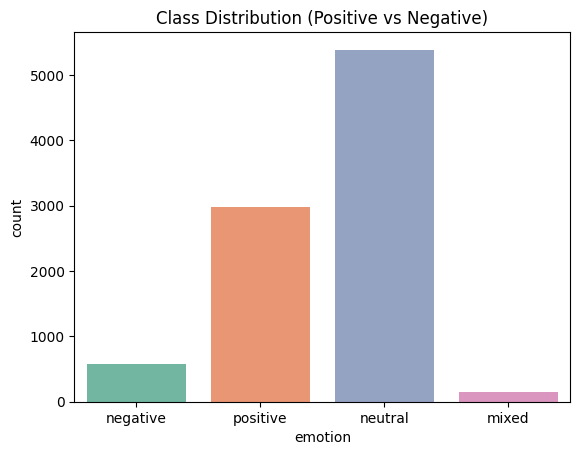

emotion
neutral     5388
positive    2978
negative     570
mixed        156
Name: count, dtype: int64


In [59]:



# Count distribution
sns.countplot(x='emotion', data= text_cleaned, palette='Set2')
plt.title("Class Distribution (Positive vs Negative)")
plt.show()

# Print raw counts
print(text_cleaned['emotion'].value_counts())

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


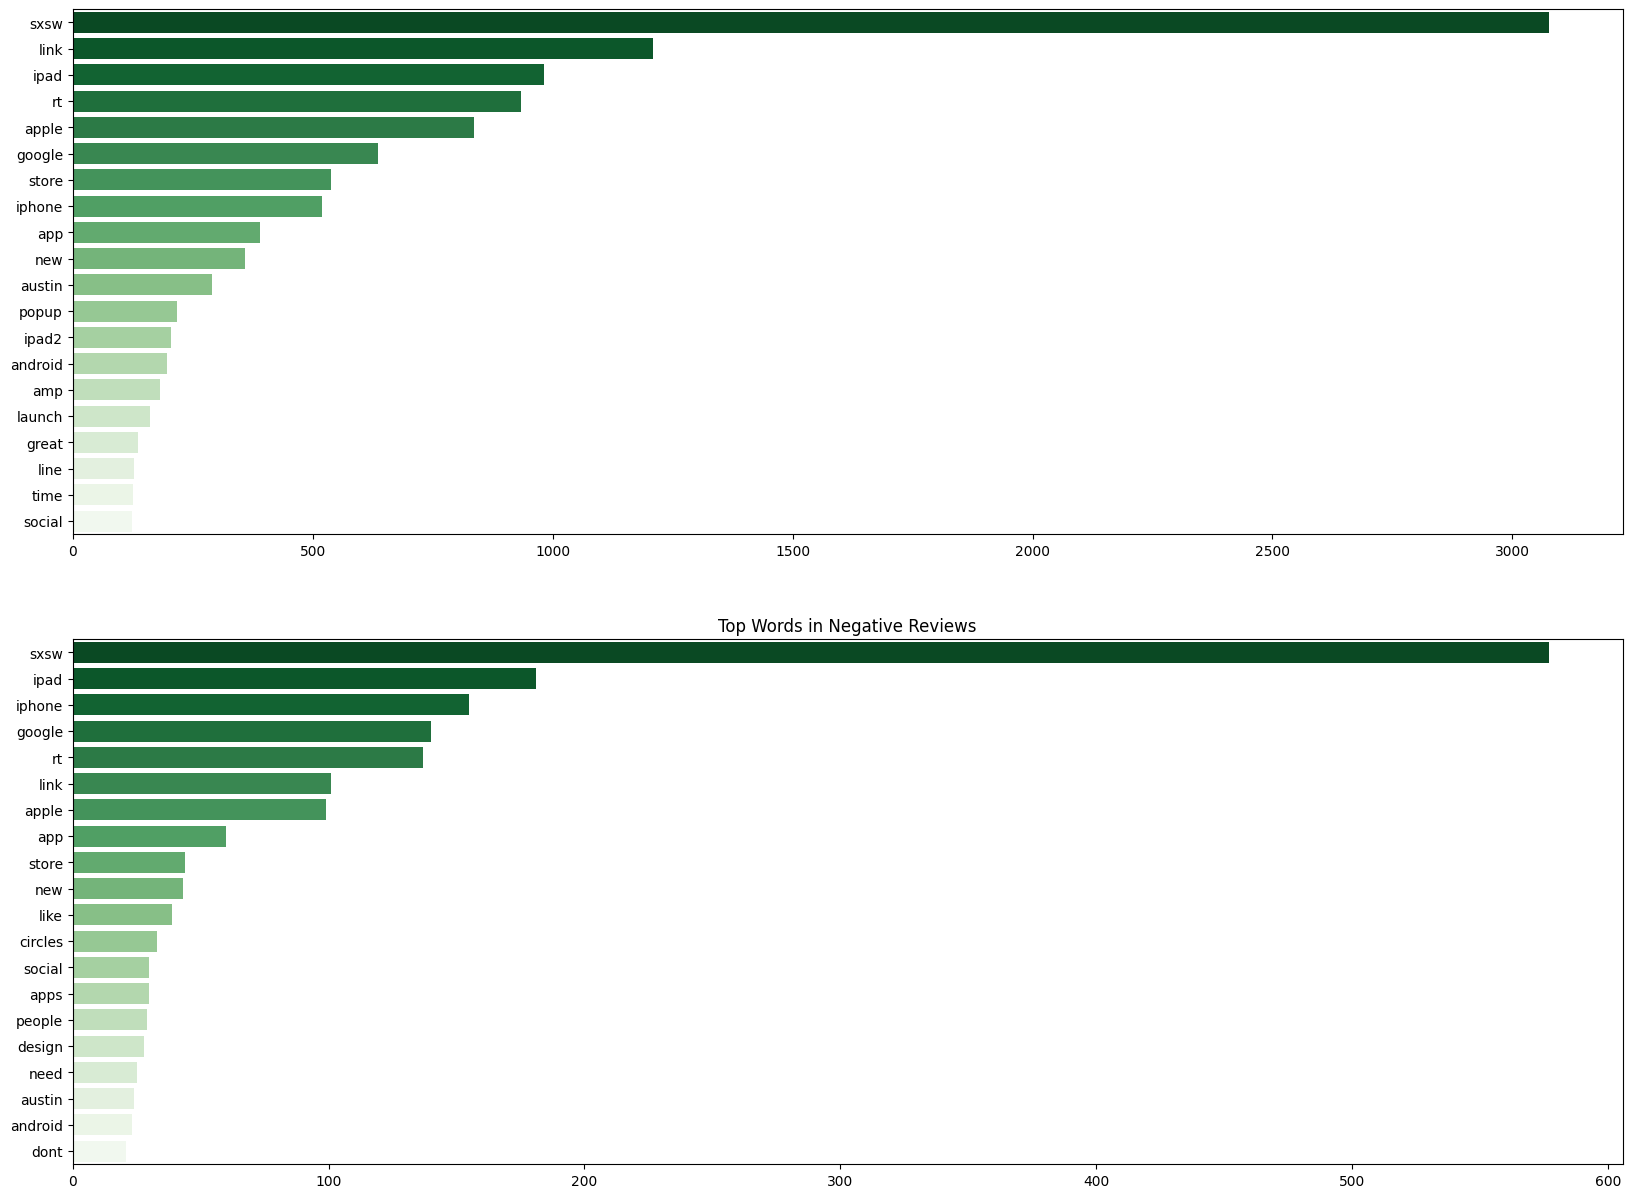

In [60]:
def get_top_words(texts, n=20):
    texts = [t for t in texts if isinstance(t, str) and t.strip() != ""]  # filter empty
    if len(texts) == 0:
        return []  # nothing to process

    vec = CountVectorizer(stop_words='english').fit(texts)
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

top_pos = get_top_words(text_cleaned[text_cleaned['emotion']=="positive"]['cleaned_tweets'])
top_neg = get_top_words(text_cleaned[text_cleaned['emotion']=="negative"]['cleaned_tweets'])

# Plotting example for positive
fig, (ax1, ax2) = plt.subplots(figsize= (20, 15), nrows= 2)

words, counts = zip(*top_pos)
sns.barplot(x=list(counts), y=list(words), palette="Greens_r", ax= ax1)
plt.title("Top Words in Positive Reviews")

words, counts = zip(*top_neg)
sns.barplot(x=list(counts), y=list(words), palette="Greens_r", ax= ax2)
plt.title("Top Words in Negative Reviews")
plt.show()


c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


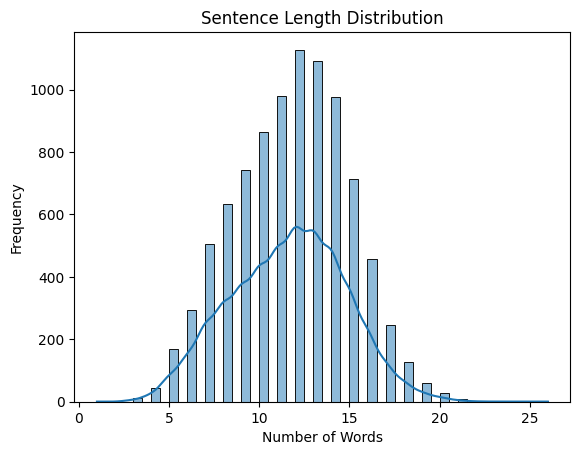

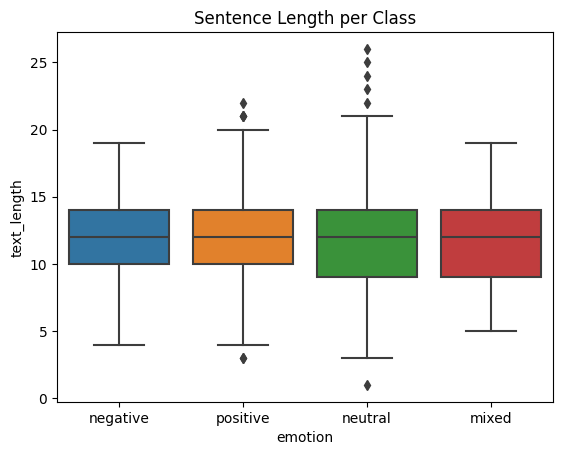

In [61]:
text_cleaned['text_length'] = text_cleaned['cleaned_tweets'].apply(lambda x: len(x.split()))

sns.histplot(text_cleaned['text_length'], bins=50, kde=True)
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Compare by class
sns.boxplot(x='emotion', y='text_length', data=text_cleaned)
plt.title("Sentence Length per Class")
plt.show()


In [62]:
# Most common words (including hashtags, mentions, etc.)... BEFORE preprocessing
all_words = ' '.join(text_cleaned['tweet']).split()
common_words = Counter(all_words).most_common(20)
print("Top 20 Most Frequent Words (Raw Tweets):")
print(common_words)

Top 20 Most Frequent Words (Raw Tweets):
[('#sxsw', 7830), ('@mention', 6703), ('the', 4357), ('{link}', 4255), ('to', 3561), ('at', 3054), ('rt', 2897), ('for', 2537), ('a', 2253), ('in', 1875), ('ipad', 1871), ('google', 1861), ('of', 1709), ('is', 1682), ('apple', 1634), ('and', 1588), ('on', 1303), ('store', 1225), ('new', 1082), ('i', 1050)]


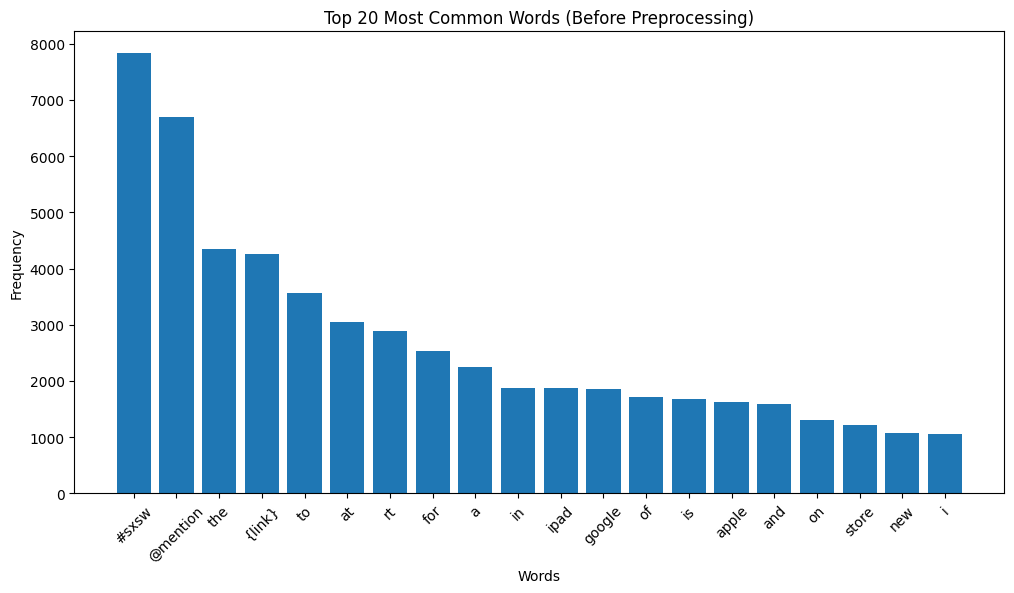

In [63]:
# Separate words and counts for plotting
Common_words = [word for word, count in common_words]
counts = [count for word, count in common_words]

# Plot
plt.figure(figsize=(12,6))
plt.bar(Common_words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Most Common Words (Before Preprocessing)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

In [64]:
# Most common words AFTER preprocessing
words = ' '.join(text_cleaned['cleaned_tweets']).split()
word_counts = Counter(words).most_common(20)

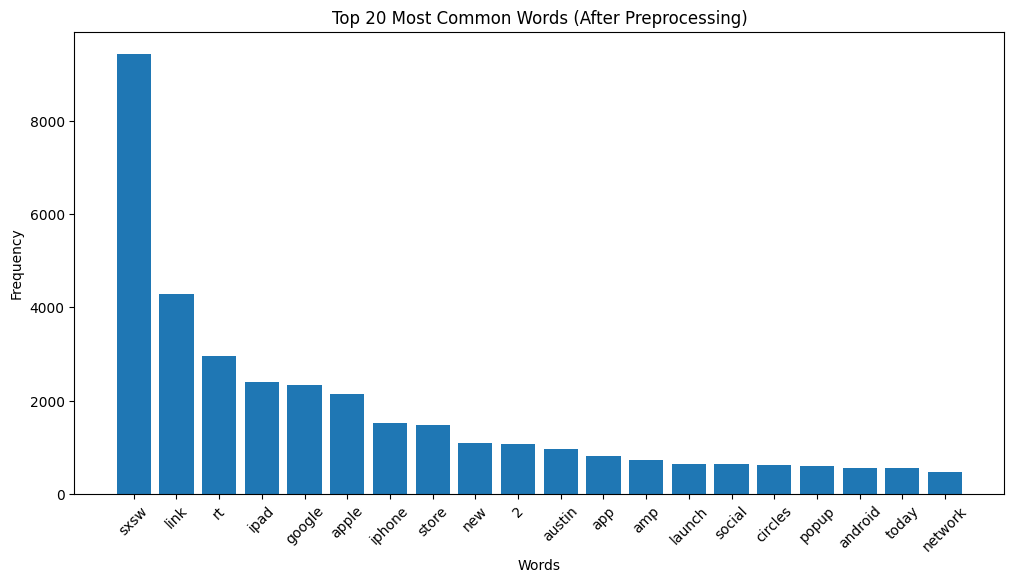

In [65]:
# Separate words and counts for plotting
common_words = [word for word, count in word_counts]
counts = [count for word, count in word_counts]

# Plot
plt.figure(figsize=(12,6))
plt.bar(common_words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Most Common Words (After Preprocessing)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

# **Binary Classification**
In this notebook, we are performing binary classifications on the tweets, focusing on the `negative` and `positive` records. This step is important to our project as it will help us work with the specified classes marking a milestone before we engage other classes.

The activities in the notebook will include;
- Importing relevant packages and loading the dataset

- Choosing relevant columns and splitting them into train, test and validation sets.

- Feature engineering.

- Training binary classification models.

## **Initial preparation**
In this step, we are importing the relevant packages and basically preparaing our data before we begin training our models.

### *Import Relevant Libraries*

In [66]:
# Load dataset
text_cleaned = pd.read_csv("../../assets/Cleaned_Tweets.csv")

# Preview the first 5 rows
text_cleaned.head()                   

,tweet,emotion,product_filled,cleaned_tweets
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,negative,iphone,3g iphone 3 hrs tweeting rise_austin dead need...
1,@jessedee know about @fludapp ? awesome ipad/i...,positive,ipad or iphone app,know awesome ipadiphone app youll likely appre...
2,@swonderlin can not wait for #ipad 2 also. the...,positive,ipad,wait ipad 2 also sale sxsw
3,@sxsw i hope this year's festival isn't as cra...,negative,ipad or iphone app,hope years festival isnt crashy years iphone a...
4,@sxtxstate great stuff on fri #sxsw: marissa m...,positive,google,great stuff fri sxsw marissa mayer google tim ...


In [67]:
# Filter the dataset to remain with negative and positive emotion
binary_df = text_cleaned[text_cleaned["emotion"].isin(['positive', 'negative'])]

# Preview filtered data
binary_df.head()

,tweet,emotion,product_filled,cleaned_tweets
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,negative,iphone,3g iphone 3 hrs tweeting rise_austin dead need...
1,@jessedee know about @fludapp ? awesome ipad/i...,positive,ipad or iphone app,know awesome ipadiphone app youll likely appre...
2,@swonderlin can not wait for #ipad 2 also. the...,positive,ipad,wait ipad 2 also sale sxsw
3,@sxsw i hope this year's festival isn't as cra...,negative,ipad or iphone app,hope years festival isnt crashy years iphone a...
4,@sxtxstate great stuff on fri #sxsw: marissa m...,positive,google,great stuff fri sxsw marissa mayer google tim ...


### *Preprocessing*
After successfully separating the data to remain with only binary classes, we are now preparing our data for modeling by;
- Selecting columns for the predictor and target variables.

- Converting our target variable to binary (0, 1)

- Splitting the data into test and train sets.

Here we are using the `cleaned_tweets` column as our predictor and the `emotion` column as our target variable.

In [68]:
# Put predictor and target columns in their respective variables.
X_binary = binary_df["cleaned_tweets"]
y_binary = binary_df["emotion"]

# Covert the y_binary column to binary.
y_binary = y_binary.map({'negative': 0, 'positive': 1})

# Split the data into train and test sets.
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

In previous projects, we've had issues in the evaluation step due to validating our models using the train set. Here we are splitting our training set further to have;
- **temp set**- This is the dataset that we are using to train the models.

- **val set**- This is the dataset that we are using to evaluate how our model generalizes to new data.

This is important because it helps us train our models better and also ensures we only use our hold out dataset after choosing our final model.

In [69]:
# Splitting the train set into temp and validation sets.
Xb_temp, Xb_val, yb_temp, yb_val= train_test_split(Xb_train, yb_train, test_size=0.2, random_state=42, stratify=yb_train)

We have successfully prepared our data for modeling.

## **Model training**
In this section, we are training our models to correctly classify whether a tweet is negative or positive.

This will include models such as;
- Logistic Regression

- SVM

- Random Forest

- XGBoost

- Gradient Descent

### *Baseline Model*
Here we are using TF-IDF to vectorize our data, and logistic regression to classify it.

In [70]:
# Define pipeline
sentiment_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=1000))
])

# Fit pipeline
sentiment_pipeline.fit(Xb_temp, yb_temp)

# Predictions
y_pred = sentiment_pipeline.predict(Xb_val)

# Evaluation
print("Classification Report:\n", classification_report(yb_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(yb_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.07      0.12        91
           1       0.85      1.00      0.92       477

    accuracy                           0.85       568
   macro avg       0.85      0.53      0.52       568
weighted avg       0.85      0.85      0.79       568

Confusion Matrix:
 [[  6  85]
 [  1 476]]


#### *SUMMARY:*
Our overall model performance is terrible, the classification report shows very poor recall for class 0 with only 7%, meaning that the model is barely predicting any negatives correctly and it’s biased toward predicting positive, class 1, almost all the time.

This is a clear indication that we have a class imbalance issue. It heavily points out that we may:
- have a heavily skewed class distribution.

Due to this, the model is learning features that mostly correlate with positives.

In the next cell, we are inspecting the class distribution in our dataset.

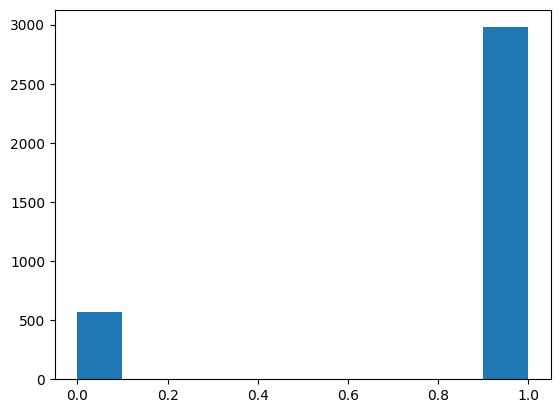

In [71]:
# Inspect class distribution
plt.hist(y_binary);

### *Applying SMOTE*
To deal with the class imbalance, we are applying SMOTE to the y_binary.

In [72]:
# Define pipeline
smote_pipeline = ImbPipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(max_iter=1000, class_weight=None))  # class_weight not needed since we use SMOTE
])

# Fit pipeline
smote_pipeline.fit(Xb_temp, yb_temp)

# Predictions
y_pred = smote_pipeline.predict(Xb_val)

# Evaluation
print("Classification Report:\n", classification_report(yb_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(yb_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.53      0.53        91
           1       0.91      0.91      0.91       477

    accuracy                           0.85       568
   macro avg       0.72      0.72      0.72       568
weighted avg       0.85      0.85      0.85       568

Confusion Matrix:
 [[ 48  43]
 [ 42 435]]


#### *SUMMARY:*
This model performed better than the baseline model, this is attributable to SMOTE. SMOTE helped the model pick up more of the minority class, class 0, compared to the previous model.

- Recall for class 0 went from 0.07 to 0.53, a big improvement meaning that now the model catches more positive cases.

- Precision for class 0 dropped from 0.86 to 0.54, which is expected, because SMOTE increases false positives.

- Class 1 stayed strong with 0.91 precision/recall, while overall accuracy stayed at 85%, but the model is now more balanced in detecting both classes.


### *Parameter Tuning*

In [73]:
# Define the parameters
param_grid = {
    "tfidf__max_features": [3000, 5000, 7000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__solver": ["liblinear", "lbfgs"],
    "clf__penalty": ["l2"]
}

# Grid search
grid_search = GridSearchCV(
    smote_pipeline,
    param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2
)

# Fit grid search
grid_search.fit(Xb_temp, yb_temp)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(Xb_val)

print("\nClassification Report:\n", classification_report(yb_val, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(yb_val, y_pred))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.49      0.54        91
           1       0.91      0.93      0.92       477

    accuracy                           0.86       568
   macro avg       0.75      0.71      0.73       568
weighted avg       0.85      0.86      0.86       568


Confusion Matrix:
 [[ 45  46]
 [ 32 445]]


#### *SUMMARY:*
This model, compared to the previous one improved, but barely;
- Recall for class 0 went from 0.53  0.48.

- Recall for class 1 stayed strong at 0.93.

However, despite the stillness and drop, the overall accuracy went up to 86%.

### *Training Multiple Binary Models*
In this section, we are training several models simultaneously.

In [74]:
# Define all models
models = {
    "SVM": LinearSVC(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {}

# Create a pipeline
for name, clf in models.items():
    pipe = ImbPipeline([
        ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ("smote", SMOTE(random_state=42)),
        ("clf", clf)
    ])
    
     # Fit
    pipe.fit(Xb_temp, yb_temp)
    
    # Predict
    y_pred = pipe.predict(Xb_val)
    
    # Evaluate
    acc = accuracy_score(yb_val, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(yb_val, y_pred))
    
    results[name] = acc

print("\nSummary:", results)
    


SVM Accuracy: 0.8662
              precision    recall  f1-score   support

           0       0.60      0.49      0.54        91
           1       0.91      0.94      0.92       477

    accuracy                           0.87       568
   macro avg       0.75      0.72      0.73       568
weighted avg       0.86      0.87      0.86       568


Random Forest Accuracy: 0.8908
              precision    recall  f1-score   support

           0       0.84      0.40      0.54        91
           1       0.90      0.99      0.94       477

    accuracy                           0.89       568
   macro avg       0.87      0.69      0.74       568
weighted avg       0.89      0.89      0.87       568



C:\Users\User\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:49:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Accuracy: 0.8574
              precision    recall  f1-score   support

           0       0.61      0.31      0.41        91
           1       0.88      0.96      0.92       477

    accuracy                           0.86       568
   macro avg       0.74      0.63      0.66       568
weighted avg       0.84      0.86      0.84       568


Gradient Boosting Accuracy: 0.8415
              precision    recall  f1-score   support

           0       0.51      0.49      0.50        91
           1       0.90      0.91      0.91       477

    accuracy                           0.84       568
   macro avg       0.70      0.70      0.70       568
weighted avg       0.84      0.84      0.84       568


Summary: {'SVM': 0.8661971830985915, 'Random Forest': 0.8908450704225352, 'XGBoost': 0.8573943661971831, 'Gradient Boosting': 0.8415492957746479}


#### *SUMMARY:*
SVM

Class 0: precision 0.60, recall 0.49, f1 0.54
→ Only ~49% of negative tweets were correctly identified. When it predicts negative, it’s right 60% of the time.

Class 1: precision 0.91, recall 0.94, f1 0.92
→ Very good at detecting positives.

Macro F1: 0.73 → average performance across classes.

Weighted F1: 0.86 → reflects class imbalance.

Random Forest

Class 0: precision 0.84, recall 0.40, f1 0.54
→ Predicts negatives less often (recall 0.40) but when it does, it’s usually correct (precision 0.84).

Class 1: precision 0.90, recall 0.99, f1 0.94 → excellent detection of positives.

Accuracy highest (0.89) but minority class recall is low, so many negatives are missed.

XGBoost

Class 0: precision 0.61, recall 0.31, f1 0.41 → struggles with negatives.

Class 1: precision 0.88, recall 0.96, f1 0.92 → strong on positives.

Overall weighted F1: 0.84.

Gradient Boosting

Class 0: precision 0.50, recall 0.49, f1 0.50 → slightly better balance for negative class.

Class 1: precision 0.90, recall 0.91, f1 0.90 → good detection of positives.

Weighted F1: 0.84.

4️ Key Takeaways

Minority class detection is poor across all models: recall for class 0 is below 0.5 for most models.

Random Forest & SVM are strongest overall, but still biased towards positives.

Gradient Boosting is more balanced on class 0 but has lower overall accuracy.

Macro F1 is useful here — it shows balanced performance across classes

In [75]:
# Define models and param grids
models_and_params = {
    "SVM": (
        LinearSVC(random_state=42),
        {
            "clf__C": [0.1, 1, 10]
        }
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10, 20]
        }
    ),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [3, 6, 10],
            "clf__learning_rate": [0.1, 0.3]
        }
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__learning_rate": [0.05, 0.1, 0.3],
            "clf__max_depth": [3, 5]
        }
    )
}

results = {}

for name, (clf, param_grid) in models_and_params.items():
    print(f"\n Running GridSearch for {name}...")
    
    pipe = ImbPipeline([
        ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ("smote", SMOTE(random_state=42)),
        ("clf", clf)
    ])
    
    grid = GridSearchCV(pipe, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
    grid.fit(Xb_temp, yb_temp)
    
    y_pred = grid.predict(Xb_val)
    
    acc = accuracy_score(yb_val, y_pred)
    print(f"{name} Best Params: {grid.best_params_}")
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(yb_val, y_pred))
    
    results[name] = {"Accuracy": acc, "Best Params": grid.best_params_}

print("\n Summary of Results:")
for model, res in results.items():
    print(f"{model}: Accuracy={res['Accuracy']:.4f}, Best Params={res['Best Params']}")


 Running GridSearch for SVM...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
SVM Best Params: {'clf__C': 1}
SVM Accuracy: 0.8662
              precision    recall  f1-score   support

           0       0.60      0.49      0.54        91
           1       0.91      0.94      0.92       477

    accuracy                           0.87       568
   macro avg       0.75      0.72      0.73       568
weighted avg       0.86      0.87      0.86       568


 Running GridSearch for Random Forest...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Random Forest Best Params: {'clf__max_depth': None, 'clf__n_estimators': 200}
Random Forest Accuracy: 0.8908
              precision    recall  f1-score   support

           0       0.84      0.40      0.54        91
           1       0.90      0.99      0.94       477

    accuracy                           0.89       568
   macro avg       0.87      0.69      0.74       568
weighted avg       0.89      0.89      0.87    

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:50:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Best Params: {'clf__learning_rate': 0.3, 'clf__max_depth': 3, 'clf__n_estimators': 200}
XGBoost Accuracy: 0.8574
              precision    recall  f1-score   support

           0       0.61      0.31      0.41        91
           1       0.88      0.96      0.92       477

    accuracy                           0.86       568
   macro avg       0.74      0.63      0.66       568
weighted avg       0.84      0.86      0.84       568


 Running GridSearch for Gradient Boosting...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Gradient Boosting Best Params: {'clf__learning_rate': 0.3, 'clf__max_depth': 3, 'clf__n_estimators': 200}
Gradient Boosting Accuracy: 0.8574
              precision    recall  f1-score   support

           0       0.57      0.45      0.50        91
           1       0.90      0.94      0.92       477

    accuracy                           0.86       568
   macro avg       0.73      0.69      0.71       568
weighted avg       0.85      0.8

1. SVM (C=1)

Accuracy: 0.87

Class 0 recall = 0.49 → means it only catches about half of the negative tweets.

Class 1 recall = 0.94 → almost perfect on positive tweets.
 Balanced, but minority class still weak.

2. Random Forest (n_estimators=200, max_depth=None)

Accuracy: 0.89 (highest overall).

Class 0 recall = 0.40 (worse than SVM).

Class 1 recall = 0.99 (almost perfect on majority class).
 Best accuracy, but very biased towards positives. Might not be fair if you care about detecting negatives.

3. XGBoost (lr=0.3, depth=3, n_estimators=200)

Accuracy: 0.86

Class 0 recall = 0.31 (lowest so far).

Class 1 recall = 0.96 (excellent).
 Again, struggles with negatives.

4. Gradient Boosting (lr=0.3, depth=3, n_estimators=200)

Accuracy: 0.86

Class 0 recall = 0.43

Class 1 recall = 0.94
 Similar to SVM, but slightly worse balance.

 Takeaway:

Random Forest gives the best accuracy (0.89) but is biased (low recall on negatives).

SVM and Gradient Boosting are more balanced (they at least get ~0.43–0.49 recall on negatives).

XGBoost underperformed here (on the minority class).

So the “best” model depends on your business goal:

If you care about catching all negative tweets (to monitor complaints), SVM or Gradient Boosting are better.

If you care more about overall accuracy, Random Forest wins.

# Model Evaluation

- In this section we will evaluate all the 5 models to find which one is the best for binary classification
- We will boil down to how the model is able to detect the positives and the negatives minimizing false positives and false negatives.

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:53:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Accuracy,Precision,Recall,F1-score,ROC-AUC
Logistic Regression,0.846831,0.846975,0.997904,0.916266,0.848435
Random Forest,0.882042,0.879630,0.995807,0.934120,0.785265
Gradient Boosting,0.860915,0.864469,0.989518,0.922776,0.777858
Linear SVM,0.876761,0.887619,0.976939,0.930140,0.851199
XGBoost,0.866197,0.874766,0.981132,0.924901,0.778573


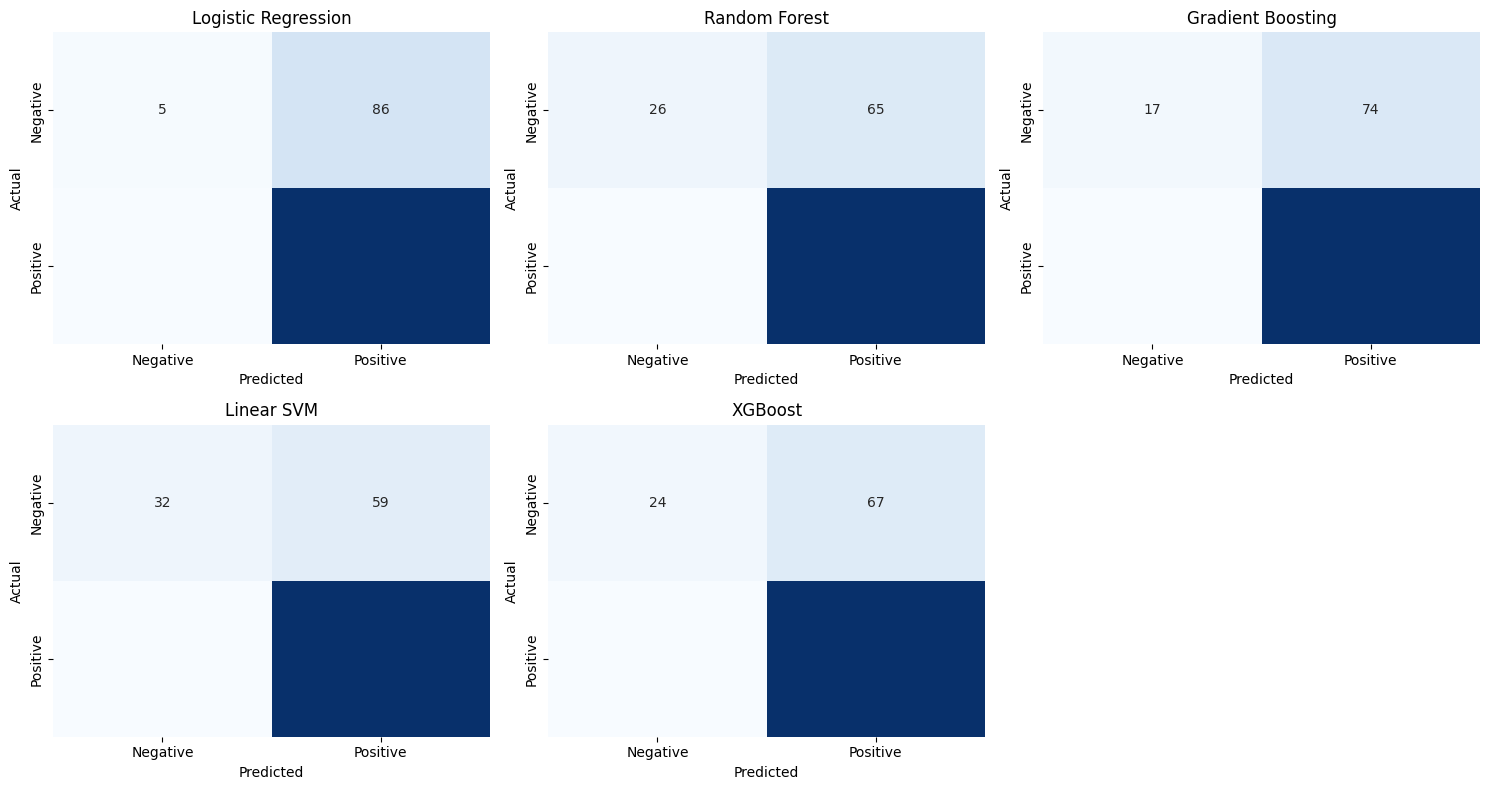

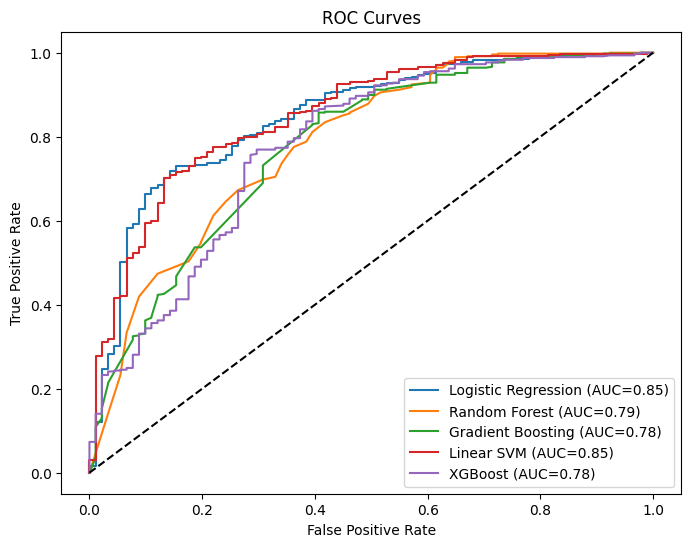

In [76]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Linear SVM": LinearSVC(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42)
}

# --------------------------
# We will store the results here
# --------------------------
results = {}
conf_matrices = {}
roc_data = {}

# --------------------------
# Single evaluation loop with the validation set
# --------------------------
for name, model in models.items():
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("clf", model)
    ])

    # Train
    pipe.fit(Xb_temp, yb_temp)

    # Predictions
    y_pred = pipe.predict(Xb_val)

    # Probas for ROC
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        y_proba = pipe.predict_proba(Xb_val)[:, 1]
    elif hasattr(pipe.named_steps["clf"], "decision_function"):
        y_proba = pipe.decision_function(Xb_val)
    else:
        y_proba = None

    # Metrics
    report = classification_report(yb_val, y_pred, output_dict=True)
    acc = accuracy_score(yb_val, y_pred)
    auc = roc_auc_score(yb_val, y_proba) if y_proba is not None else None

    results[name] = {
        "Accuracy": acc,
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
        "ROC-AUC": auc
    }

    # Confusion matrix
    conf_matrices[name] = confusion_matrix(yb_val, y_pred)

    # ROC data
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(yb_val, y_proba)
        roc_data[name] = (fpr, tpr, auc)

# --------------------------
# Results Table
# --------------------------
results_df = pd.DataFrame(results).T
display(results_df)

# --------------------------
# Confusion Matrices Heatmaps
# --------------------------
n_models = len(conf_matrices)
cols = 3
rows = (n_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))

for ax, (name, cm) in zip(axes.flatten(), conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"], ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# Remove unused subplots
for ax in axes.flatten()[len(conf_matrices):]:
    ax.remove()

plt.tight_layout()
plt.show()

# --------------------------
# ROC Curves
# --------------------------
plt.figure(figsize=(8,6))
for name, (fpr, tpr, auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

## 📊 Model Evaluation Results

| Model                | Accuracy | Precision | Recall  | F1-Score | ROC-AUC |
|-----------------------|----------|-----------|---------|----------|---------|
| Logistic Regression   | **0.847** | 0.847     | **0.998** | 0.916    | 0.848   |
| Random Forest         | **0.882** | 0.880     | **0.996** | **0.934** | 0.785   |
| Gradient Boosting     | 0.861    | 0.864     | 0.990   | 0.923    | 0.778   |
| Linear SVM            | 0.877    | **0.888** | 0.977   | 0.930    | **0.851** |
| XGBoost               | 0.866    | 0.875     | 0.981   | 0.925    | 0.779   |

Analysis of Model Performance Metrics
This table compares five different machine learning models across five key evaluation metrics. The high Recall scores across all models suggest the dataset might have a class imbalance, meaning one class (likely the positive class) has significantly more examples than the other.

Here is a breakdown of each model's performance:

Logistic Regression: Shows solid and balanced performance across all metrics. Its high Recall (0.998) means it is excellent at identifying positive cases, but its Precision (0.847) is lower than others, indicating it has more false positives. Its ROC-AUC is strong, confirming good overall separability.

Random Forest: This is the top-performing model in terms of overall accuracy (0.882) and F1-score (0.934). It achieves the best balance between Precision and Recall. However, its ROC-AUC score (0.785) is surprisingly the lowest, which can sometimes happen with imbalanced data and might warrant a closer look at the probability calibrations.

Gradient Boosting & XGBoost: These two boosting algorithms perform very similarly. They have good but not top-tier Accuracy and F1-scores. Their key weakness is a relatively low ROC-AUC, similar to Random Forest, suggesting their ability to distinguish between classes is less robust than Logistic Regression or SVM.

Linear SVM: Demonstrates very strong performance, boasting the highest Precision (0.888) and a very high F1-score (0.930). This means when it predicts a positive, it is most likely to be correct. Its high ROC-AUC score is second only to Logistic Regression, indicating excellent model confidence.

Summary and Recommendation
Best Overall Model: Random Forest, due to its highest Accuracy and F1-score, which best balances the trade-off between false positives and false negatives.

Best for High-Certainty Predictions: Linear SVM, if your priority is minimizing false positives (i.e., you want to be very sure a prediction is positive when you make it).

Key Observation: All models have exceptionally high Recall (>0.97). This means they are all very good at capturing nearly all positive instances in the data. The primary differences between them lie in how many false positives they generate (reflected in Precision).

-----

## Multiclass-Classification

#### Here we are to introduce another label named `neutral` in addition to the `negative` and `positive` 

In [77]:
# --- 1. Import Libraries ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline


import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [78]:
# --- 2. Load Data ---
text_cleaned = pd.read_csv("../../assets/Cleaned_Tweets.csv")
text_cleaned.head()

,tweet,emotion,product_filled,cleaned_tweets
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,negative,iphone,3g iphone 3 hrs tweeting rise_austin dead need...
1,@jessedee know about @fludapp ? awesome ipad/i...,positive,ipad or iphone app,know awesome ipadiphone app youll likely appre...
2,@swonderlin can not wait for #ipad 2 also. the...,positive,ipad,wait ipad 2 also sale sxsw
3,@sxsw i hope this year's festival isn't as cra...,negative,ipad or iphone app,hope years festival isnt crashy years iphone a...
4,@sxtxstate great stuff on fri #sxsw: marissa m...,positive,google,great stuff fri sxsw marissa mayer google tim ...


In [79]:
multi_df = text_cleaned[text_cleaned["emotion"].isin(['positive', 'negative','neutral'])]
multi_df

,tweet,emotion,product_filled,cleaned_tweets
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,negative,iphone,3g iphone 3 hrs tweeting rise_austin dead need...
1,@jessedee know about @fludapp ? awesome ipad/i...,positive,ipad or iphone app,know awesome ipadiphone app youll likely appre...
2,@swonderlin can not wait for #ipad 2 also. the...,positive,ipad,wait ipad 2 also sale sxsw
3,@sxsw i hope this year's festival isn't as cra...,negative,ipad or iphone app,hope years festival isnt crashy years iphone a...
4,@sxtxstate great stuff on fri #sxsw: marissa m...,positive,google,great stuff fri sxsw marissa mayer google tim ...
...,...,...,...,...
9087,ipad everywhere. #sxsw {link},positive,ipad,ipad everywhere sxsw link
9088,"wave, buzz... rt @mention we interrupt your re...",neutral,google,wave buzz rt interrupt regularly scheduled sxs...
9089,"google's zeiger, a physician never reported po...",neutral,google,googles zeiger physician never reported potent...
9090,some verizon iphone customers complained their...,neutral,iphone,verizon iphone customers complained time fell ...


In [80]:
X_multi = multi_df["cleaned_tweets"]
y_multi = multi_df["emotion"]

y_multi = y_multi.map({'negative': 0, 'positive': 1, 'neutral': 2})


Xmultib_train, Xmultib_test, ymultib_train, ymultib_test = train_test_split(
    X_multi, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

### - Splitting data into test, train and validation data to be able to both train, test and validate our models

In [81]:
Xmultib_temp, Xmultib_val, ymultib_temp, ymultib_val= train_test_split(
    Xmultib_train, ymultib_train, test_size=0.2, random_state=42, stratify=ymultib_train
)

### Baseline Model (Logistic Regression ) with TDIDF

In [82]:
sentiment_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=1000))
])

# Fit pipeline
sentiment_pipeline.fit(Xmultib_temp, ymultib_temp)

# Predictions
y_pred = sentiment_pipeline.predict(Xmultib_val)

# Evaluation
print("Classification Report:\n", classification_report(ymultib_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(ymultib_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.09      0.16        91
           1       0.63      0.47      0.54       477
           2       0.70      0.87      0.78       862

    accuracy                           0.69      1430
   macro avg       0.74      0.48      0.49      1430
weighted avg       0.69      0.69      0.66      1430

Confusion Matrix:
 [[  8  18  65]
 [  1 225 251]
 [  0 113 749]]


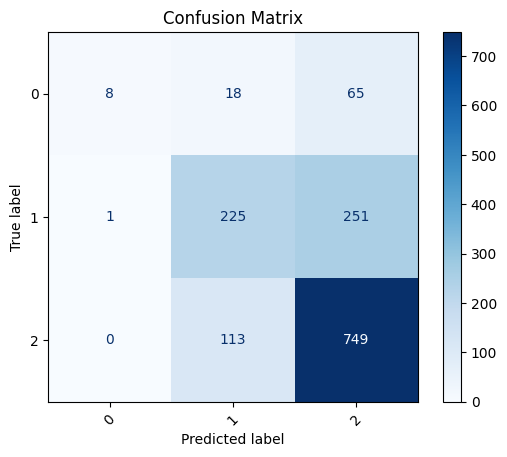

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = sentiment_pipeline.predict(Xmultib_val)
cm = confusion_matrix(ymultib_val, y_pred)
labels = sentiment_pipeline.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", values_format="d", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


- The model performs **best on class 2** (good recall and precision).  
- It struggles **heavily with class 0**, where most samples are wrongly classified as class 2.  
- Class 1 has **moderate performance**, but a large portion is still misclassified as class 2.  
- The imbalance in class distribution (class 2 has the most samples) likely contributes to the poor recall of minority classes (especially class 0).

###  Managing class imbalance with SMOTE

In [84]:
smote_pipeline = ImbPipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(max_iter=1000, class_weight=None))  # class_weight not needed since we use SMOTE
])

# Fit pipeline
smote_pipeline.fit(Xmultib_temp, ymultib_temp)

# Predictions
y_pred = smote_pipeline.predict(Xmultib_val)

# Evaluation
print("Classification Report:\n", classification_report(ymultib_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(ymultib_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.42      0.35        91
           1       0.56      0.59      0.57       477
           2       0.75      0.70      0.72       862

    accuracy                           0.64      1430
   macro avg       0.54      0.57      0.55      1430
weighted avg       0.66      0.64      0.65      1430

Confusion Matrix:
 [[ 38  22  31]
 [ 29 282 166]
 [ 57 204 601]]


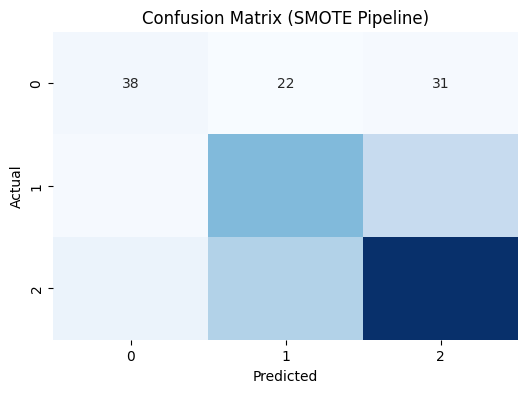

In [85]:

y_pred = smote_pipeline.predict(Xmultib_val)
cm = confusion_matrix(ymultib_val, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=smote_pipeline.classes_,
            yticklabels=smote_pipeline.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (SMOTE Pipeline)")
plt.show()



1. **SMOTE greatly improved recall for Class 0**, which was nearly ignored before.  
2. The model is now **more balanced across all three classes** (macro recall improved from 0.48 → 0.57).  
3. Accuracy dropped slightly (69% → 64%), but this is expected because the model now prioritizes **fairness across classes** instead of always favoring the majority class.  
4. Trade-off: More false positives for Class 0, but much better representation overall.  


## GRID SEARCH      

In [86]:
from sklearn.model_selection import GridSearchCV     
param_grid = {
    "tfidf__max_features": [3000, 5000, 7000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__solver": ["liblinear", "lbfgs"],
    "clf__penalty": ["l2"] 
}

# Grid search
grid_search = GridSearchCV(
    smote_pipeline,
    param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2
)

# Fit grid search
grid_search.fit(Xmultib_train, ymultib_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(Xmultib_test)

from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:\n", classification_report(ymultib_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(ymultib_test, y_pred))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 1)}

Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.53      0.46       114
           1       0.58      0.64      0.61       596
           2       0.77      0.70      0.73      1078

    accuracy                           0.67      1788
   macro avg       0.59      0.62      0.60      1788
weighted avg       0.68      0.67      0.67      1788


Confusion Matrix:
 [[ 60  20  34]
 [ 22 381 193]
 [ 63 259 756]]


Interpretation by Class

1. Class 0 (minority, 114 samples):

- Recall improved to 0.53, meaning the model is now catching more than half of these cases.
- Precision is lower (0.41), showing some false positives, but this is a fair trade-off for better recall.

2. Class 1 (596 samples):

- Balanced performance (Precision = 0.58, Recall = 0.64, F1 = 0.61).
- Model is doing better than before in both capturing class 1 and keeping false positives under control.

3. Class 2 (majority, 1078 samples):

- Strongest performance overall: Precision = 0.77, Recall = 0.70.
- Slight trade-off between recall and precision, but still the best-performing class.

### Pipeline with Different Models (SVM, RANDOM FOREST, XGBOOST, GRADIENT BOOSTING)

In [87]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score



models = {
    "SVM": LinearSVC(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {}

for name, clf in models.items():
    pipe = ImbPipeline([
        ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ("smote", SMOTE(random_state=42)),
        ("clf", clf)
    ])
    
     # Fit
    pipe.fit(Xmultib_temp, ymultib_temp)
    
    # Predict
    y_pred = pipe.predict(Xmultib_val)
    
    # Evaluate
    acc = accuracy_score(ymultib_val, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(ymultib_val, y_pred))
    
    results[name] = acc

print("\nSummary of Results:", results)



SVM Accuracy: 0.6399
              precision    recall  f1-score   support

           0       0.33      0.35      0.34        91
           1       0.55      0.60      0.57       477
           2       0.74      0.69      0.72       862

    accuracy                           0.64      1430
   macro avg       0.54      0.55      0.54      1430
weighted avg       0.65      0.64      0.64      1430


Random Forest Accuracy: 0.6874
              precision    recall  f1-score   support

           0       0.51      0.22      0.31        91
           1       0.64      0.50      0.56       477
           2       0.71      0.84      0.77       862

    accuracy                           0.69      1430
   macro avg       0.62      0.52      0.55      1430
weighted avg       0.67      0.69      0.67      1430



C:\Users\User\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:56:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Accuracy: 0.6601
              precision    recall  f1-score   support

           0       0.33      0.21      0.26        91
           1       0.61      0.45      0.52       477
           2       0.70      0.82      0.76       862

    accuracy                           0.66      1430
   macro avg       0.54      0.49      0.51      1430
weighted avg       0.64      0.66      0.64      1430


Gradient Boosting Accuracy: 0.6168
              precision    recall  f1-score   support

           0       0.21      0.35      0.26        91
           1       0.58      0.44      0.50       477
           2       0.70      0.74      0.72       862

    accuracy                           0.62      1430
   macro avg       0.50      0.51      0.49      1430
weighted avg       0.63      0.62      0.62      1430


Summary of Results: {'SVM': 0.6398601398601399, 'Random Forest': 0.6874125874125874, 'XGBoost': 0.6601398601398601, 'Gradient Boosting': 0.6167832167832168}


### Fine Tuning the Models

In [88]:
# Define models and param grids
from sklearn.metrics import f1_score


models_and_params = {
    "SVM": (
        LinearSVC(random_state=42),
        {
            "clf__C": [0.1, 1, 10]
        }
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10, 20]
        }
    ),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [3, 6, 10],
            "clf__learning_rate": [0.1, 0.3]
        }
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__learning_rate": [0.05, 0.1, 0.3],
            "clf__max_depth": [3, 5]
        }
    )
}

results = {}

for name, (clf, param_grid) in models_and_params.items():
    print(f"\n Running GridSearch for {name}...")
    
    pipe = ImbPipeline([
        ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ("smote", SMOTE(random_state=42)),
        ("clf", clf)
    ])
    
    grid = GridSearchCV(pipe, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
    grid.fit(Xmultib_temp, ymultib_temp)
    
    y_pred = grid.predict(Xmultib_val)
    
    acc = accuracy_score(ymultib_val, y_pred)
    f1 = f1_score(ymultib_val, y_pred, average="macro")

    print(f"{name} Best Params: {grid.best_params_}")
    print(f"{name} Accuracy: {acc:.4f},  Macro F1: {f1:.4f}")
    print(classification_report(ymultib_val, y_pred))
    
    results[name] = {"Accuracy": acc, "Best Params": grid.best_params_}

print("\n Summary of Results:")
for model, res in results.items():
    print(f"{model}: Accuracy={res['Accuracy']:.4f}, Best Params={res['Best Params']}")


 Running GridSearch for SVM...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
SVM Best Params: {'clf__C': 1}
SVM Accuracy: 0.6399,  Macro F1: 0.5422
              precision    recall  f1-score   support

           0       0.33      0.35      0.34        91
           1       0.55      0.60      0.57       477
           2       0.74      0.69      0.72       862

    accuracy                           0.64      1430
   macro avg       0.54      0.55      0.54      1430
weighted avg       0.65      0.64      0.64      1430


 Running GridSearch for Random Forest...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Random Forest Best Params: {'clf__max_depth': None, 'clf__n_estimators': 200}
Random Forest Accuracy: 0.6874,  Macro F1: 0.5463
              precision    recall  f1-score   support

           0       0.51      0.22      0.31        91
           1       0.64      0.50      0.56       477
           2       0.71      0.84      0.77       862

    accur

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [22:05:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Best Params: {'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 200}
XGBoost Accuracy: 0.6699,  Macro F1: 0.5123
              precision    recall  f1-score   support

           0       0.34      0.19      0.24        91
           1       0.62      0.47      0.53       477
           2       0.70      0.83      0.76       862

    accuracy                           0.67      1430
   macro avg       0.55      0.50      0.51      1430
weighted avg       0.65      0.67      0.65      1430


 Running GridSearch for Gradient Boosting...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Gradient Boosting Best Params: {'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__n_estimators': 200}
Gradient Boosting Accuracy: 0.6664,  Macro F1: 0.5424
              precision    recall  f1-score   support

           0       0.40      0.26      0.32        91
           1       0.58      0.54      0.56       477
           2       0.72      0.78      0.75     

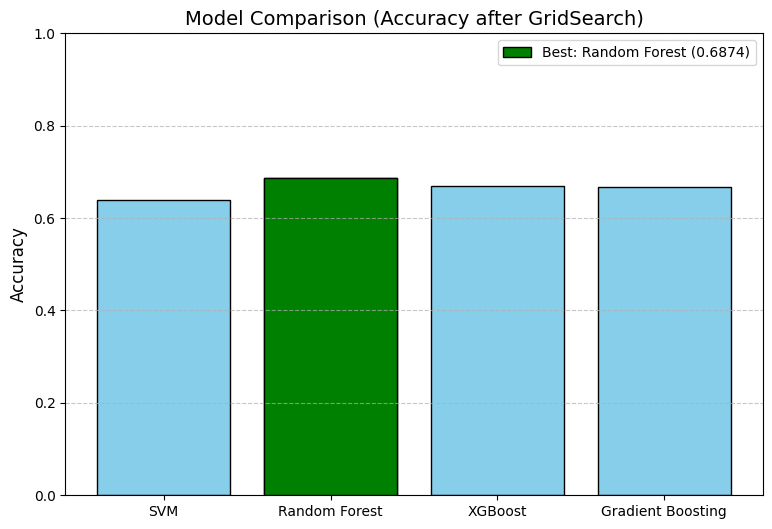


 Best Model: Random Forest
   Accuracy: 0.6874
   Best Params: {'clf__max_depth': None, 'clf__n_estimators': 200}


In [89]:
plt.figure(figsize=(9,6))
accuracies = {m: res["Accuracy"] for m, res in results.items()}
plt.bar(accuracies.keys(), accuracies.values(), color="skyblue", edgecolor="black")

# Highlight best model
best_model = max(accuracies, key=accuracies.get)
best_acc = accuracies[best_model]
plt.bar(best_model, best_acc, color="green", edgecolor="black",
        label=f"Best: {best_model} ({best_acc:.4f})")

plt.title("Model Comparison (Accuracy after GridSearch)", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0,1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.show()

print(f"\n Best Model: {best_model}")
print(f"   Accuracy: {best_acc:.4f}")
print(f"   Best Params: {results[best_model]['Best Params']}")






### Here the best model is Random Forest
we will use this pipeline to train and get the best models measuring accuracy and f1 score and then save the model using joblib

In [90]:
from sklearn.metrics import f1_score, accuracy_score, classification_report
import joblib

models_and_params = {
    "SVM": (
        LinearSVC(random_state=42),
        {
            "clf__C": [0.1, 1, 10]
        }
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10, 20]
        }
    ),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [3, 6, 10],
            "clf__learning_rate": [0.1, 0.3]
        }
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__learning_rate": [0.05, 0.1, 0.3],
            "clf__max_depth": [3, 5]
        }
    )
}

results = {}
best_model = None
best_model_name = None
best_f1 = -1  # keep track of best macro f1 score

for name, (clf, param_grid) in models_and_params.items():
    print(f"\n Running GridSearch for {name}...")
    
    pipe = ImbPipeline([
        ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ("smote", SMOTE(random_state=42)),
        ("clf", clf)
    ])
    
    grid = GridSearchCV(pipe, param_grid, cv=3, scoring="f1_macro", n_jobs=-1, verbose=1)
    grid.fit(Xmultib_temp, ymultib_temp)
    
    y_pred = grid.predict(Xmultib_val)
    
    acc = accuracy_score(ymultib_val, y_pred)
    f1 = f1_score(ymultib_val, y_pred, average="macro")

    print(f"{name} Best Params: {grid.best_params_}")
    print(f"{name} Accuracy: {acc:.4f},  Macro F1: {f1:.4f}")
    print(classification_report(ymultib_val, y_pred))
    
    results[name] = {
        "Accuracy": acc,
        "Macro F1": f1,
        "Best Params": grid.best_params_,
        "Best Estimator": grid.best_estimator_
    }

    # track the best model by macro f1
    if f1 > best_f1:
        best_f1 = f1
        best_model = grid.best_estimator_
        best_model_name = name

print("\n Summary of Results:")
for model, res in results.items():
    print(f"{model}: Accuracy={res['Accuracy']:.4f}, Macro F1={res['Macro F1']:.4f}, Best Params={res['Best Params']}")

# Save the best model
joblib.dump(best_model, f"best_model_{best_model_name.replace(' ', '_').lower()}.pkl")
print(f"\nBest model saved as best_model_{best_model_name.replace(' ', '_').lower()}.pkl (Model: {best_model_name}, Macro F1={best_f1:.4f})")



 Running GridSearch for SVM...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
SVM Best Params: {'clf__C': 1}
SVM Accuracy: 0.6399,  Macro F1: 0.5422
              precision    recall  f1-score   support

           0       0.33      0.35      0.34        91
           1       0.55      0.60      0.57       477
           2       0.74      0.69      0.72       862

    accuracy                           0.64      1430
   macro avg       0.54      0.55      0.54      1430
weighted avg       0.65      0.64      0.64      1430


 Running GridSearch for Random Forest...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Random Forest Best Params: {'clf__max_depth': None, 'clf__n_estimators': 100}
Random Forest Accuracy: 0.6867,  Macro F1: 0.5424
              precision    recall  f1-score   support

           0       0.51      0.21      0.30        91
           1       0.62      0.50      0.56       477
           2       0.72      0.84      0.77       862

    accur

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [22:25:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Best Params: {'clf__learning_rate': 0.3, 'clf__max_depth': 10, 'clf__n_estimators': 100}
XGBoost Accuracy: 0.6720,  Macro F1: 0.5190
              precision    recall  f1-score   support

           0       0.38      0.19      0.25        91
           1       0.60      0.50      0.54       477
           2       0.71      0.82      0.76       862

    accuracy                           0.67      1430
   macro avg       0.56      0.50      0.52      1430
weighted avg       0.65      0.67      0.66      1430


 Running GridSearch for Gradient Boosting...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Gradient Boosting Best Params: {'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__n_estimators': 100}
Gradient Boosting Accuracy: 0.6671,  Macro F1: 0.5348
              precision    recall  f1-score   support

           0       0.32      0.26      0.29        91
           1       0.60      0.52      0.56       477
           2       0.72      0.79      0.75     

### BERT

In [91]:
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Use same labels as your notebook
label2id = {"negative": 0, "positive": 1, "neutral": 2}
id2label = {v: k for k, v in label2id.items()}

df = pd.DataFrame({"text": X_multi, "label": y_multi})

# Train/val/test split
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["text"], df["label"], test_size=0.3, stratify=df["label"], random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

train_df = pd.DataFrame({"text": train_texts, "label": train_labels})
val_df   = pd.DataFrame({"text": val_texts, "label": val_labels})
test_df  = pd.DataFrame({"text": test_texts, "label": test_labels})

train_dataset = Dataset.from_pandas(train_df)
val_dataset   = Dataset.from_pandas(val_df)
test_dataset  = Dataset.from_pandas(test_df)


##  Tokenize Text with BERT Tokenizer

In [93]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset   = val_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/6255 [00:00<?, ? examples/s]

Map:   0%|          | 0/1340 [00:00<?, ? examples/s]

Map:   0%|          | 0/1341 [00:00<?, ? examples/s]

### Define BERT Model

In [94]:
from transformers import BertForSequenceClassification

num_labels = len(label2id)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training Setup

In [95]:

from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}



In [96]:
training_args = TrainingArguments(
    output_dir="./results",
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
)

### Train BERT


In [ ]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
    
# )

# trainer.train()


C:\Users\User\AppData\Local\Temp\ipykernel_22740\984575968.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.696238,0.678358,0.425088,0.794384,0.431369
2,0.746000,0.655312,0.711194,0.601812,0.648322,0.577742
3,0.515400,0.713067,0.712687,0.622946,0.628478,0.618224


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1173, training_loss=0.5976742860707888, metrics={'train_runtime': 50473.5947, 'train_samples_per_second': 0.372, 'train_steps_per_second': 0.023, 'total_flos': 1234330820916480.0, 'train_loss': 0.5976742860707888, 'epoch': 3.0})

# Training Output 

### **Global Step**
- **Value:** `1173`  
- Represents the total number of update steps completed during training.  
- Each step usually corresponds to one batch of training data.

---

### **Training Loss**
- **Value:** `0.5976742860707888`  
- The final average training loss after all epochs.  
- Lower values generally indicate better fitting of the model to the training data.

---

### **Metrics**

1. **Train Runtime**
   - **Value:** `50473.5947` seconds (~14 hours)  
   - The total time taken for the entire training process.

2. **Train Samples per Second**
   - **Value:** `0.372` samples/sec  
   - The throughput: how many training samples the model processed each second.  
   - Low values usually indicate that the training setup is computationally heavy.

3. **Train Steps per Second**
   - **Value:** `0.023` steps/sec  
   - The number of optimizer update steps per second.  
   - Reflects how fast batches are processed.

4. **Total FLOPs**
   - **Value:** `1.23433082091648e+15`  
   - Estimated number of floating-point operations performed during training.  
   - This shows the computational cost.

5. **Train Loss**
   - **Value:** `0.5976742860707888`  
   - Duplicate of the training loss (for convenience in the metrics dictionary).  

6. **Epoch**
   - **Value:** `3.0`  
   - Total number of times the entire dataset was passed through the model.

---

### **Summary**
- The model was trained for **3 epochs**.  
- It completed **1173 steps** in ~14 hours.  
- The average loss is **~0.598**, showing moderate performance.  
- Training speed is **very low (0.372 samples/sec)**, suggesting opportunities to optimize the training process (e.g., smaller model, mixed precision training, smaller batch size, or GPU acceleration).

---


### 

In [ ]:
# results = trainer.evaluate(test_dataset)
# print(results)


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.6717896461486816, 'eval_accuracy': 0.7307979120059657, 'eval_f1': 0.6152632572431611, 'eval_precision': 0.6755409572886318, 'eval_recall': 0.5892976072524452, 'eval_runtime': 727.4195, 'eval_samples_per_second': 1.844, 'eval_steps_per_second': 0.115, 'epoch': 3.0}


##  Model Evaluation Summary (Epoch 3)

- **Loss**: `0.67` → Model still makes some errors, but acceptable for text classification.
- **Accuracy**: **73.1%** → About 73% of predictions were correct.
- **F1 Score**: **0.62** → Balanced precision/recall performance; moderate overall.
- **Precision**: **0.68** → When the model predicts a label, it is correct ~68% of the time.
- **Recall**: **0.59** → Captures ~59% of the true labels (misses some).
- **Runtime**: **727s (~12 minutes)**  
  - ~**1.84 samples/sec**  
  - ~**0.12 steps/sec**

---

###  Interpretation
- Model is **more precise than sensitive** (higher precision than recall).  
- Accuracy (73%) is solid, but recall (59%) shows it misses some cases.  
- F1 score (0.62) reflects **moderate performance** — decent baseline but improvable.  

---

  


 ----

###  1. Load the saved model

In [101]:
import joblib

# Load the saved model
best_model = joblib.load("best_model_random_forest.pkl")


###  2. Run on test data

In [103]:
# Predict on test set
y_pred = best_model.predict(Xmultib_test)

# Evaluate performance
from sklearn.metrics import classification_report, f1_score, accuracy_score

print("Accuracy:", accuracy_score(ymultib_test, y_pred))
print("Macro F1:", f1_score(ymultib_test, y_pred, average="macro"))
print("\nClassification Report:\n", classification_report(ymultib_test, y_pred))


Accuracy: 0.6700223713646533
Macro F1: 0.5481858415706459

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.25      0.35       114
           1       0.59      0.51      0.54       596
           2       0.71      0.80      0.75      1078

    accuracy                           0.67      1788
   macro avg       0.61      0.52      0.55      1788
weighted avg       0.66      0.67      0.66      1788



### 3. Predict on new unseen data

In [108]:
new_texts = [
    "I hate hate hate product!", 
    "love love happy."
]

predictions = best_model.predict(new_texts)

print(predictions)


[2 2]


### Recommendations


1. General Sentiment Trends – Track overall positive vs. negative sentiment (e.g., “60% positive, 40% negative”) and address spikes in negativity with responsive campaigns.

2. Positive Drivers – Amplify what users already love (e.g., Google Pixel’s camera, iPhone’s ecosystem) through ads, influencer marketing, and social proof.

3. Negative Pain Points – Identify top complaints (e.g., iPhone battery life, Android bloatware) and directly counter them with messaging, feature highlights, or improved support.

4. Competitive Benchmarking – Compare sentiment across Apple vs. Google, iPhone vs. Android, and use competitor weaknesses as positioning opportunities.

5. Actionable Monitoring – Build a live dashboard to track sentiment shifts after launches or campaigns, ensuring marketing actions are data-driven and adaptive.